# Running OPE with the dataset previously created


In [1]:
from torch.utils.data import DataLoader
from policy_eval.dataset import F110Dataset # this is a dataset wrapper for OPE


import f110_gym
import f110_orl_dataset
import gymnasium as gym

from f110_orl_dataset.normalize_dataset import Normalize
import numpy as np
import torch
from f110_orl_dataset.normalize_dataset import Normalize

In [2]:
from tensorboardX import SummaryWriter
import os


In [3]:
def get_infinite_iterator(dataloader):
    while True:
        for data in dataloader:
            yield data


# Get the training dataset

In [21]:
# load the dataset
F110Env = gym.make('f110_with_dataset-v0',
# only terminals are available as of right now 
    **dict(name='f110_with_dataset-v0',
        config = dict(map="Infsaal", num_agents=1,
        params=dict(vmin=0.0, vmax=2.0)),
        render_mode="human")
)
env = F110Env
behavior_dataset = F110Dataset(
    env,
    normalize_states=True,
    normalize_rewards=False, #have this since some time, should reconsider
    path = f"/home/fabian/msc/f110_dope/ws_release/datasets_1412.zarr", #trajectories.zarr",
    exclude_agents = ['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0',
                      'StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0',
                      'StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0',
                      'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0'],#,'StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0'], #'progress_weight', 'raceline_delta_weight', 'min_action_weight'],#['det'], #+ [FLAGS.target_policy] , #+ ["min_lida", "raceline"],
    alternate_reward=False, # only set this to true if recomputed the reward
    include_timesteps_in_obs = True, # I'm not sure if this still does something
    only_terminals=True, # do not use truncate - for FQE important
    clip_trajectory_length= (0,250), # look at 0 to 250 timesteps
    sample_from_trajectories= 1, # we can subsample the trajectories
    )

dataloader = DataLoader(behavior_dataset, batch_size=256, shuffle=True)
inf_dataloader = get_infinite_iterator(dataloader)
data_iter = iter(inf_dataloader)

{'config': {'map': 'Infsaal', 'num_agents': 1, 'params': {'vmin': 0.0, 'vmax': 2.0}}, 'render_mode': 'human'}
Infsaal_map.pgm
Infsaal_map.pgm
hi
Infsaal_map.pgm
Infsaal_map.pgm
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.     -30.      -1.      -1.     -20.     -20.     -20.      -0.4189
   0.5     -1.      -1.    ], [30.     30.      1.      1.     20.     20.     20.      0.4189  2.
  1.      1.    ], (11,), float32)
***********
/home/fabian/msc/f110_dope/ws_release/datasets_1412.zarr


/home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(
/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0']
len(model_names) 400145
Indices: 200086
[150059 150060 150061 ... 350142 350143 350144]
(200086,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_x
poses_y
previous_action
progress_cos
progress_sin
theta_cos
theta_sin
Number of timesteps: 99836
initial states torch.Size([401, 11])


# Now lets load an Agent

In [5]:
from f110_agents.agent import Agent
actor = Agent().load("agent_configs/ftg_fast.json") # have to tidy this up
save_path = f"runs/{str(actor)}"
print(save_path)
hparam_str = "test"
writer = SummaryWriter(log_dir= os.path.join(save_path, hparam_str))

model_input_normalizer = Normalize() # this was introduced for RL agents, can be considered a bit of a baggage now, might remove this at some point
subsample_laser = 20 # this is hardcoded across multiple files right now, will refactor 

Agent parameters {'speed_multiplier': 0.5, 'gap_blocker': 2}
runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0


Just execute the next cell.

In [22]:
"""
@brief input shape is (batch_size, obs_dim), state needs to be normalized!!
"""
def get_target_actions(states, action_timesteps=None, scans= None, batch_size=5000):
    num_batches = int(np.ceil(len(states) / batch_size))
    actions_list = []
    # batching, s.t. we dont run OOM
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(states))
        batch_states = states[start_idx:end_idx].clone()

        # unnormalize from the dope dataset normalization
        batch_states_unnorm = behavior_dataset.unnormalize_states(batch_states) # this needs batches
        del batch_states
        batch_states_unnorm = batch_states_unnorm.cpu().numpy()

        # get scans
        if scans is not None:
            laser_scan = scans[start_idx:end_idx].cpu().numpy()
        else:
            laser_scan = F110Env.get_laser_scan(batch_states_unnorm, subsample_laser) # TODO! rename f110env to dataset_env
            #print("Scan 1")
            #print(laser_scan)
            laser_scan = model_input_normalizer.normalize_laser_scan(laser_scan)
        #print("Scan 2")
        #print(laser_scan)
        # back to dict
        model_input_dict = model_input_normalizer.unflatten_batch(batch_states_unnorm)
        # normalize back to model input
        model_input_dict = model_input_normalizer.normalize_obs_batch(model_input_dict)
        
        # now also append the laser scan
        model_input_dict['lidar_occupancy'] = laser_scan
        #print("model input dict")
        # print(model_input_dict)
        batch_actions = actor(
        model_input_dict,
        std=None)[1]
        #print(batch_actions)
        
        actions_list.append(batch_actions)
    # tf.concat(actions_list, axis=0)
    # with torch
    # convert to torch tensor
    actions_list = [torch.from_numpy(action) for action in actions_list]
    actions = torch.concat(actions_list, axis=0)
    # print(actions)
    return actions.float()

def get_target_logprobs(states,actions,action_timesteps=None,scans=None, batch_size=5000):
    num_batches = int(np.ceil(len(states) / batch_size))
    log_probs_list = []
    for i in range(num_batches):
        # print(i)
        # Calculate start and end indices for the current batch
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(states))
        # Extract the current batch of states
        batch_states = states[start_idx:end_idx]
        batch_states_unnorm = behavior_dataset.unnormalize_states(batch_states)
        
        # Extract the current batch of actions
        batch_actions = actions[start_idx:end_idx]

        # get scans
        if scans is not None:
            laser_scan = scans[start_idx:end_idx].cpu().numpy()
        else:
            laser_scan = F110Env.get_laser_scan(batch_states_unnorm, subsample_laser) # TODO! rename f110env to dataset_env
            laser_scan = model_input_normalizer.normalize_laser_scan(laser_scan)

        # back to dict
        model_input_dict = model_input_normalizer.unflatten_batch(batch_states_unnorm)
        # normalize back to model input
        model_input_dict = model_input_normalizer.normalize_obs_batch(model_input_dict)
        # now also append the laser scan
        model_input_dict['lidar_occupancy'] = laser_scan

        # Compute log_probs for the current batch
        batch_log_probs = actor(
            model_input_dict,
            actions=batch_actions,
            std=None)[2]
        
        # Sum along the last axis if the rank is greater than 1
        # print("len logprobs", print(batch_log_probs.shape))
        
        # Collect the batch_log_probs
        log_probs_list.append(batch_log_probs)
    # Concatenate the collected log_probs from all batches
    log_probs = [torch.from_numpy(log_prob) for log_prob in log_probs_list]
    log_probs = torch.concat(log_probs, axis=0)
    return log_probs.float()

# OPE
First, lets import one of the available OPE methods. Only FQE and DR are currently tested in this setting, and I'm not sure if the other methods will currently work! To have a look at how they should be used you can look into `train_torch.py`

In [11]:
discount = 0.99
update_steps = 100_000
min_reward = behavior_dataset.rewards.min()
max_reward = behavior_dataset.rewards.max()

In [12]:
from policy_eval.q_fitter import QFitter
model = QFitter(behavior_dataset.states.shape[1],#env.observation_spec().shape[0],
                    env.action_spec().shape[1], 
                    critic_lr=3e-5, 
                    weight_decay=1e-5,
                    tau=0.005, 
                    discount = 0.99,
                    use_time=True, 
                    timestep_constant = behavior_dataset.timestep_constant,
                    writer=writer)
# change this to compare multiple models
model_name = "fast"

In [13]:
print(model.critic)

CriticNet(
  (fc1): Linear(in_features=14, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [15]:
from tqdm import tqdm
stds2 = []
means2 = []
for i in tqdm(range(update_steps)):
    
  (states, scans, actions, next_states, next_scans, rewards, masks, weights,
    log_prob, timesteps) = next(data_iter)
  
  # Model update
  next_actions = get_target_actions(next_states, scans=next_scans)

  max_r = (max_reward*max(250,50)) # the length of the dataset times the maximum reward we can find in it
  model.update(states, actions, next_states, 
                next_actions, rewards, masks,
                weights, discount, 
                min_reward = min_reward, 
                max_reward= max_r, 
                timesteps=timesteps)
  ## EVALUATION
  if i % 10_000 == 0:
    pred_returns, std = model.estimate_returns(behavior_dataset.initial_states,
                                    behavior_dataset.initial_weights,
                                    get_target_actions,
                                    torch.zeros(behavior_dataset.initial_states.shape[0],1))
    pred_returns = behavior_dataset.unnormalize_rewards(pred_returns)
    std = behavior_dataset.unnormalize_rewards(std)
    #print(pred_returns)
    # print(std)
    pred_returns *= (1-discount)
    std *= (1-discount)
    print("normed,", pred_returns)
    model.save(save_path, i=0) # always save to zero, whatever
    # print("saved as", save_path, 0)
    stds2.append(std)
    means2.append(pred_returns)

  0%|          | 12/100000 [00:01<1:52:20, 14.83it/s]

normed, tensor(0.0122)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


  5%|▌         | 5023/100000 [00:38<11:49, 133.82it/s]

normed, tensor(0.0420)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 10%|█         | 10017/100000 [01:12<12:17, 122.01it/s]

normed, tensor(0.1225)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 15%|█▌        | 15022/100000 [01:49<11:08, 127.17it/s]

normed, tensor(0.2098)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 20%|██        | 20014/100000 [02:25<11:44, 113.51it/s]

normed, tensor(0.2588)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 25%|██▌       | 25014/100000 [03:01<14:53, 83.93it/s] 

normed, tensor(0.2725)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 30%|███       | 30015/100000 [03:42<09:28, 123.21it/s]

normed, tensor(0.2714)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 35%|███▌      | 35025/100000 [04:17<07:40, 140.99it/s]

normed, tensor(0.2723)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 40%|████      | 40024/100000 [04:53<07:22, 135.67it/s]

normed, tensor(0.2751)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 45%|████▌     | 45021/100000 [05:31<07:21, 124.50it/s]

normed, tensor(0.2735)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 50%|█████     | 50024/100000 [06:09<05:47, 143.66it/s]

normed, tensor(0.2688)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 55%|█████▌    | 55029/100000 [06:42<04:49, 155.54it/s]

normed, tensor(0.2628)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 60%|██████    | 60027/100000 [07:17<04:52, 136.49it/s]

normed, tensor(0.2582)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 65%|██████▌   | 65024/100000 [07:53<04:56, 118.11it/s]

normed, tensor(0.2529)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 70%|███████   | 70028/100000 [08:30<03:46, 132.31it/s]

normed, tensor(0.2518)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 75%|███████▌  | 75035/100000 [09:04<02:38, 157.87it/s]

normed, tensor(0.2510)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 80%|████████  | 80021/100000 [09:40<02:41, 123.72it/s]

normed, tensor(0.2561)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 85%|████████▌ | 85022/100000 [10:17<02:05, 119.70it/s]

normed, tensor(0.2603)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 90%|█████████ | 90030/100000 [10:54<01:10, 141.56it/s]

normed, tensor(0.2650)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


 95%|█████████▌| 95028/100000 [11:29<00:39, 125.85it/s]

normed, tensor(0.2655)
saved as runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0 0


100%|██████████| 100000/100000 [12:05<00:00, 137.83it/s]


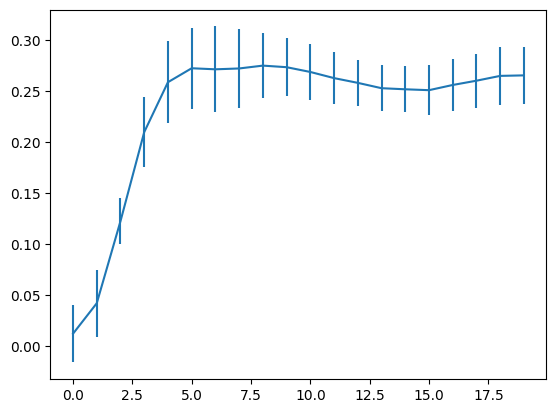

In [16]:
# plot std and means
import matplotlib.pyplot as plt
y = np.arange(len(means2))
plt.errorbar(y,means2, yerr=stds2)
plt.show()

# DR

In order to run DR we need FQE agents (or any other direct method)

Lets load one of the saved FQE agents

In [23]:
fqe_load = f"/home/fabian/msc/f110_dope/ws_release/runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0"
print("Loading from ", fqe_load)
model.load(fqe_load,
            i=0)

Loading from  /home/fabian/msc/f110_dope/ws_release/runs/StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0


behavior_log_probs cpu
behavior_dataset.states cpu
behavior_dataset.actions cpu
behavior_dataset.scans cpu
nans, behavior_log_probs tensor(0)
Finished Q value computation


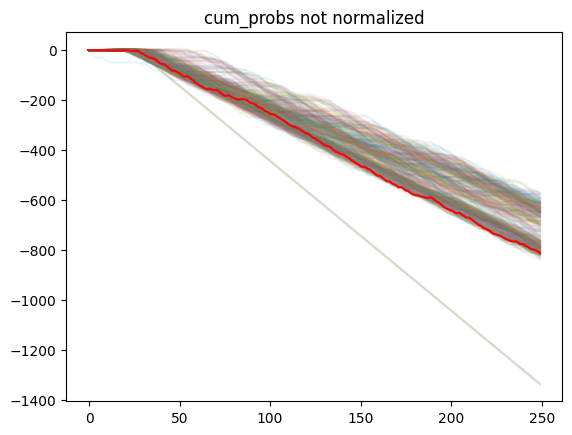

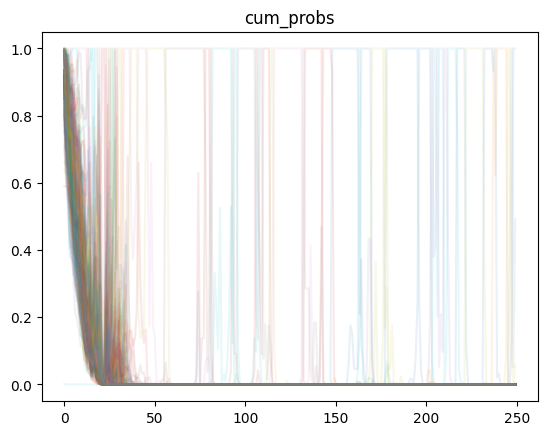

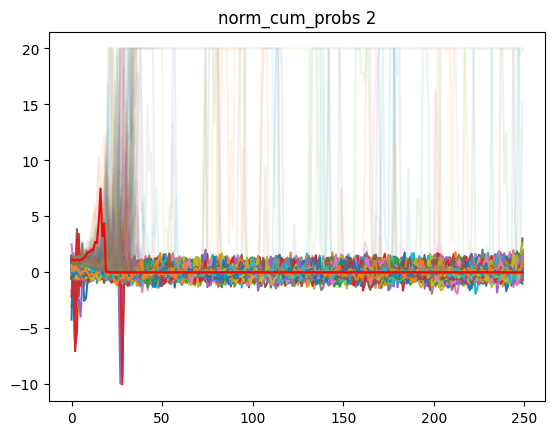

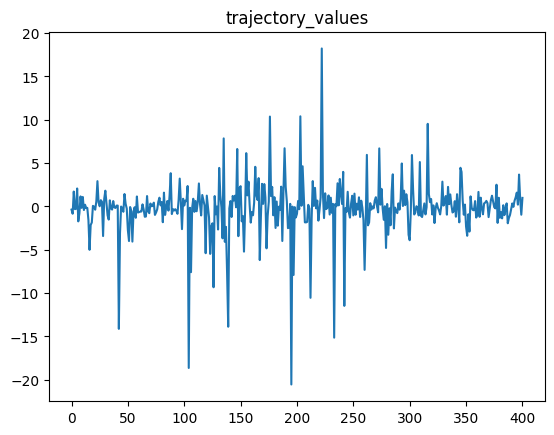

pred returns tensor(0.2636)
std tensor(0.0591)


In [24]:
from policy_eval.doubly_robust import DR_estimator

dr_model = DR_estimator(model, behavior_dataset, discount)
pred_return, pred_std = dr_model.estimate_returns(get_target_actions, get_target_logprobs, algo="fqe")
pred_returns = behavior_dataset.unnormalize_rewards(pred_return)
std = behavior_dataset.unnormalize_rewards(pred_std)
pred_returns *= (1-discount)
std *= (1-discount)
print("pred returns", pred_returns)
print("std", std)